# Section II.

## Dask image parallelization dev notebook

Created on: Monday March 28th, 2022  
Created by: Jacob Alexander Rose  

In [1]:
# %%bash

import os

# os.environ["OMP_NUM_THREADS"]="1"
# export MKL_NUM_THREADS=1
# export OPENBLAS_NUM_THREADS=1
# echo '${OMP_NUM_THREADS}'

In [2]:
# source: https://examples.dask.org/machine-learning/torch-prediction.html
from typing import *

import glob
import toolz
import dask
import dask.array as da
import torch
from torchvision import transforms
from PIL import Image
import pandas as pd
pd.set_option("display.max_colwidth", 150)
import numpy as np
# from imutils.ml.data.datamodule import Herbarium2022DataModule, Herbarium2022Dataset
import os
from pathlib import Path
# import dask
import dask.dataframe as dd
#####################################################
from rich import print as pp
from dataclasses import dataclass, field

import distributed

from dask import distributed as ddistributed

In [3]:
from dask.diagnostics import ProgressBar
# from dask.distributed import Client, performance_report

from distributed import Client, performance_report 

In [4]:
# cluster = distributed.LocalCluster(dashboard_address=":44295",
#                                    threads_per_worker=8, processes=4)  # could customize with different kwargs
# client = distributed.Client(cluster,
#                            name="JAR_dask_client")
#                            # scheduler_port="44295")

# client = Client("127.0.0.1:8989")  # start distributed scheduler locally.
# client

# client

In [5]:
@dataclass
class Config:
    source_root_dir: Path = Path('/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize')
    target_root_dir_template: Path = Path('/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize')
    target_resolution: int = 512
    target_root_dir: str = field(init=False)
    
    def __post_init__(self):
        self.target_root_dir = Path(f"{str(self.target_root_dir_template)}-{self.target_resolution}")
        os.makedirs(self.target_root_dir, exist_ok=True)
        
    def get_target_path(self, source_path: Path) -> Path:
        """
        Finds the source path's location relative to the source root, and returns a new path at the same location relative to the target root.
        
        - source and target root dirs are specified at instantiation of config, must update instance attributes in order to chaange this method.
        """
        return str(self.target_root_dir / Path(source_path).relative_to(self.source_root_dir))
    
    def process_full_dataframe(self, data_df: pd.DataFrame) -> pd.DataFrame:
        """
        Prepare dataframe for large-scale image file processing.
        
        Creates a `target_path` column in data_df and fills it with values produced by self.get_target_path, then renames is as `path` while renaming the original colmn `path` to be `source_path`.
        
        """
        data_df = data_df.assign(target_path = data_df.path.apply(self.get_target_path, meta=("target_path", "string")))
        data_df = data_df.rename(columns={"path":"source_path",
                                          "target_path":"path"})
        # data_df = data_df.sort_index()
        
        return data_df
    
    
    def read_dask_dataframe_from_csv(self,
                                    csv_path: str,
                                    columns: List[str],
                                    col_dtypes: Dict[str, Any]) -> dd.DataFrame:
        
        data_df = dd.read_csv(csv_path, usecols=["Unnamed: 0", *columns], dtype=col_dtypes
                              ).rename(columns={"Unnamed: 0":"idx"})
        data_df = data_df.set_index("idx")
        # data_df = data_df.sort_index()
        data_df = data_df.repartition(16)
        
        return data_df
    
    def read_and_process(self,
                         csv_path: str,
                         columns: List[str],
                         col_dtypes: Dict[str, Any]) -> dd.DataFrame:
        """
        Calls 2 methods in sequence to read from csv, then process dataframe in preparation for performing expensive computations on big data.
        
        """
        data_df = self.read_dask_dataframe_from_csv(csv_path=csv_path,
                                                    columns=columns,
                                                    col_dtypes=col_dtypes)
        data_df = self.process_full_dataframe(data_df)
        
        return data_df
    
    
    
cfg = Config()
pp(cfg)


catalog_dir = "/media/data/jacob/GitHub/image-utils/imutils/big/data"

train_csv_path = Path(catalog_dir, "train_metadata.csv")
test_csv_path = Path(catalog_dir, "test_metadata.csv")

train_columns = ['path', 'image_id',
           'category_id', 'genus_id', 'scientificName', 
           'Species', 'institution_id',
           'family', 'genus', 'species', 
           'file_name', 'collectionCode']

train_col_dtypes = {'path':"string",
                    'image_id':"string",
                    'category_id': "category",
                    'genus_id': "category",
                    'scientificName': "category",
                    'Species': "category",
                    'institution_id': "category",
                    'family': "category",
                    'genus': "category",
                    'species': "category",
                    'file_name': "string",
                    'collectionCode': "category"}

test_columns = ['path', 'image_id', 'file_name']
test_col_dtypes = {'path':"string",
                    'image_id':"string",
                    'file_name': "string"}




train_df = cfg.read_and_process(csv_path=train_csv_path,
                                columns=train_columns,
                                col_dtypes=train_col_dtypes)

test_df = cfg.read_and_process(csv_path=test_csv_path,
                               columns=test_columns,
                               col_dtypes=test_col_dtypes)

Config(
    source_root_dir=PosixPath('/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-
2022-fgvc9_resize'),
    target_root_dir_template=PosixPath('/media/data_cifs/projects/prj_fossils/data/raw_data/h
erbarium-2022-fgvc9_resize'),
    target_resolution=512,
    target_root_dir=PosixPath('/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-
2022-fgvc9_resize-512')
)

### Save processed catalogs to target directory

In [6]:
train_catalog_out_path = Path(cfg.target_root_dir, "train_metadata.csv")
test_catalog_out_path = Path(cfg.target_root_dir, "test_metadata.csv")

if not os.path.isfile(train_catalog_out_path):
    train_df.to_csv(train_catalog_out_path, single_file=True)
if not os.path.isfile(test_catalog_out_path):
    test_df.to_csv(test_catalog_out_path, single_file=True)

# test_df.head()
!ls -alh {cfg.target_root_dir}

total 351M
drwxrwxrwx 2 cis-storage cis-storage 2.0K Mar 30 05:21 .
drwxrwxrwx 2 cis-storage cis-storage  10K Mar 29 00:25 ..
drwxrwxrwx 2 cis-storage cis-storage 112K Mar 30 05:22 test_images
-rwxrwxrwx 1 cis-storage cis-storage  53M Mar 30 05:19 test_metadata.csv
drwxrwxrwx 2 cis-storage cis-storage  78K Mar 30 00:34 train_images
-rwxrwxrwx 1 cis-storage cis-storage 299M Mar 30 05:18 train_metadata.csv


In [7]:
@dask.delayed
def load(path: str,
         fs=__builtins__):
    with fs.open(path, 'rb') as f:
        img = Image.open(f).convert("RGB")
        return img



@dask.delayed
def process(img: Image.Image,
            size: int):
    img = img.resize(size=(size,size),
                     resample=Image.BICUBIC)
    return img

@dask.delayed
def save(img: Image.Image,
         target_path: str,
         fs=__builtins__):
    with fs.open(target_path, 'wb') as f:
        img = img.save(f, format="jpeg")
    return os.path.isfile(target_path)


@dask.delayed
def run_one(row: dd.Series,
            resize_resolution: int) -> bool:
    """
    If no file exists at row.path: load, process & save the image at row.source_path.
    
    Returns True if image exists at target location
    
    """
    # print(type(row), row)
    # if os.path.isfile(row.path):
        # print(row.path)
    # if dask.delayed(os.path.isfile(row.path.values):
        # Automatically mark row as a success if file already exists.
        # User should perform a more robust final check after the main script runs to check for any corrupted files.
        # return True

    img = load(path=row.source_path)
    img = process(img=img, size=resize_resolution)
    outcome = save(img=img, target_path=row.path)
    return outcome


# @dask.delayed
def run(data_chunk: dd.DataFrame,
        resize_resolution: int) -> List[bool]:
    """
    If no file exists at row.path: load, process & save the image at row.source_path.
    
    Returns True if image exists at target location
    
    """
    results = []
    # with ProgressBar() as pbar:
        # for i, row in enumerate(data_chunk.iterrows()):
        # for i, row in tqdm(data_chunk.iterrows()):
    for i, row in data_chunk.iterrows():
        outcome = run_one(row=row,
                          resize_resolution=resize_resolution)
        results.append(outcome)

    return results

In [8]:
%%time
from tqdm import tqdm 
import time

def timer(function):
    """
    Simple Wrapper function for timing execution of a single function call.
    """
    def _wrapped(*args, **kwargs):
        print(f"STARTING function: {function.__name__} -- ({time.ctime()})")
        start = time.time()
        output = function(*args, **kwargs)
        end = time.time()
        print(f"FINISHED function: {function.__name__} -- ({time.ctime()}) -- Duration: {end-start:.5f} seconds")
        return output
    return _wrapped

# @timer
# def testing_function(*args, **kwargs):
#     print(f"We're in the testing function")
#     time.sleep(2)

# # testing_function()#*args, **kwargs)

@timer
def create_output_dirs(data_df: Union[pd.DataFrame, dd.DataFrame],
                       expected_total: Optional[int]=15501
                      ) -> List[str]:
    """ Useful helper function for bulk transfer of files from one location to another.
    Extracts all possible output dirs containing files listed in `path` column, and creates them if they don't exist.
    
    Throws an error if any still don't exist after function execution.
    
    Returns a list of the output_dir paths as str.
    
    """
    # Extract the unique directories
    if isinstance(data_df, pd.DataFrame):
        output_dirs = list(set(data_df.path.apply(lambda x: str(Path(x).parent))))
    elif isinstance(data_df, dd.DataFrame):
        output_dirs = list(set(data_df.path.apply(lambda x: str(Path(x).parent), meta=("path","string")).compute()))
    else:
        raise TypeError(f"data_df must be either a dask or pandas DataFrame. Invalid type provided: {type(data_df)}")
    
    # Optional: If user knows total number of directories in advance, raise an error if the number extracted differs at all.
    if isinstance(expected_total, int) and expected_total > 0:
        assert len(output_dirs) == expected_total # 15501

    # Attempt to create any directories that don't yet exist, and throw an error if any still remain.
    for out in tqdm(output_dirs):
        os.makedirs(out, exist_ok=True)
        assert os.path.isdir(out), f"Nonexistent target dir: {out}"
        
    return output_dirs


CPU times: user 0 ns, sys: 660 µs, total: 660 µs
Wall time: 7.72 ms


In [9]:
@timer
def execute_full_run(data_df: dd.DataFrame,
                     target_resolution: int=512,
                     profiler: Optional=None) -> List[List[bool]]:

    # out_df = data_df.map_partitions(run, resize_resolution=target_resolution, meta=bool)
    
    # if profiler is None:
    #     profiler = ProgressBar()
    
    with ProgressBar(minimum=0.5) as pbar:
    #     results = out_df.compute()
    #     computed_results = dask.compute(*results)
    # shape = client.compute(out_df.shape)
    # pp(f"Computing out_df with shape: {shape}, and npartitions: {out_df.npartitions}")
        out_df = data_df.map_partitions(run, resize_resolution=target_resolution, meta=("results",bool))

        results = dask.compute(*out_df)
        computed_results = dask.compute(*results)

        
    # print(f"FINISHED")
    return computed_results, pbar

@timer
def count_dask_outcomes(computed_results: List[List[bool]]) -> None:
    """
    Helper function for quickly assessing basic diagnostic info about an image processing task performed by dask.
    
    Displays:
        - Total images
        - Total successfully processed images
        - Total **un**successfully processed images
    
    Arguments:
        computed_results: List[List[bool]]
            This is returned by `execute_full_run()` after it's mapped a `run` function across partitions. It is a list, each element of which is a list of bools.
                - One bool per image processing operation
                - One list of bools per DataFrame partition
                - One list of lists of bools per total-dataset DataFrame
    
    """
    partition_sums = [(sum(p), len(p)) for p in computed_results]
    correct = 0
    total = 0
    for num_correct, num_total in partition_sums:
        correct += num_correct
        total += num_total
    incorrect = total - correct
    print(f"Total images Processed: {total}")
    print(f"# successful: {correct}",
          f"# unsuccessful: {incorrect}")

In [10]:
# from dask.diagnostics import ProgressBar
# from dask.distributed import Client, performance_report #progress

# from dask.distributed import Client
# client = Client("127.0.0.1:8989")  # start distributed scheduler locally.
# client

In [11]:
target_resolution=512

## Test on small subset

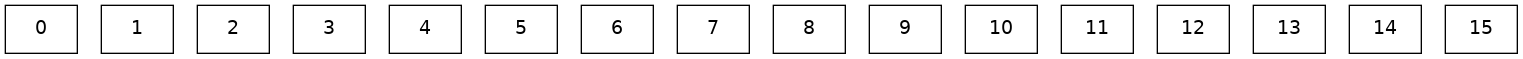

In [12]:
# test_df.visualize()
test_df = test_df.persist()
test_df.visualize()

#### Take a small fraction of dataset for testing

(210407, 4)


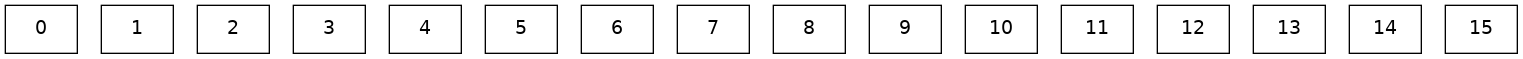

In [13]:
seed = 85+1+2+3+4+5
random_state = np.random.RandomState(seed=seed)

# data_df = train_df.sample(frac=0.001,
#                          replace=False,
#                          random_state=random_state)

# data_df = test_df.sample(frac=0.5,
#                          replace=False,
#                          random_state=random_state)

data_df = test_df #.tail(n=1000)


data_df = data_df.persist()
print(dask.compute(*data_df.shape))
data_df.visualize()

In [14]:
data_df = data_df.repartition(npartitions=100)
data_df = data_df.persist()

In [15]:
# client.gather(data_df).compute_current_divisions()
# data_rows = list(data_df.to_dask_array(lengths=True).to_records())
# data_rows = list(data_df.iterrows())
# out_df = client.map(run_one, , resize_resolution=target_resolution)#, meta=("results",bool))
# type(out_df[0])
# out_df.visualize()
# o = client.gather(out_df)
# dask.visualize(*out_df)


# out_df = data_df.map_partitions(run, resize_resolution=target_resolution, meta=("results",bool))
# out_df.visualize()

In [16]:
computed_results, pbar = execute_full_run(data_df=data_df,
                                    target_resolution=512)#,
                                    # profiler=ProgressBar())

count_dask_outcomes(computed_results)
pbar

STARTING function: execute_full_run -- (Wed Mar 30 11:38:24 2022)
[########################################] | 100% Completed |  1min 19.4s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.9s
[########################################] |

In [ ]:
# count_dask_outcomes(computed_results)
out = dask.compute(computed_results)

In [18]:
# data_df = data_df.persist()
# out_df.dask
# computed_out_df = client.compute(out_df)
# # target_resolution=512
# computed_out_df.result()
# # target_resolution=512
# data_df.head()
# from PIL import Image
# path = "/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/test_images/004/test-004810.jpg"
# img = Image.open(path)

## Process train images:

In [17]:
train_output_dirs = create_output_dirs(train_df,
                                      expected_total=None)

print(len(train_output_dirs))

STARTING function: create_output_dirs -- (Wed Mar 30 13:42:33 2022)


100%|█████████████████████████████████████████████████████████████████████████████████████████| 15501/15501 [06:37<00:00, 39.02it/s]

FINISHED function: create_output_dirs -- (Wed Mar 30 13:50:08 2022) -- Duration: 455.16792 seconds
15501


In [18]:

# with distributed.progress as prog:
computed_results = execute_full_run(data_df=train_df, #.sample(frac=0.5,replace=False,random_state=random_state),
                                    target_resolution=target_resolution)#,
                                    # profiler=performance_report("res=512 -- test images resizing - half of all imgs.html"))

count_dask_outcomes(computed_results)

[########################################] | 100% Completed |  6hr  0min 46.0s
FINISHED function: execute_full_run -- (Wed Mar 30 20:31:14 2022) -- Duration: 24065.81299 seconds
STARTING function: count_dask_outcomes -- (Wed Mar 30 20:31:14 2022)


TypeError: unsupported operand type(s) for +: 'int' and 'list'

In [23]:
839772 + 210407

1050179

In [21]:
24000/60/60

6.666666666666667

## Process test images:

In [ ]:
# dask.config.set(fuse_subgraphs=False)

test_output_dirs = create_output_dirs(test_df,
                                      expected_total=None)

print(len(test_output_dirs))

In [ ]:

# with distributed.progress as prog:
computed_results = execute_full_run(data_df=test_df, #.sample(frac=0.5,replace=False,random_state=random_state),
                                    target_resolution=target_resolution)#,
                                    # profiler=performance_report("res=512 -- test images resizing - half of all imgs.html"))

count_dask_outcomes(computed_results)

STARTING (Wed Mar 30 07:33:00 2022)


## END

In [20]:
# train_df = dd.read_csv(train_csv_path, usecols=["Unnamed: 0", *train_columns], dtype=train_col_dtypes
#                       ).rename(columns={"Unnamed: 0":"idx"})
# train_df = train_df.set_index("idx")
# train_df = train_df.repartition(16)
# train_df.head()


# data_df = data_df.assign(target_path = data_df.path.apply(cfg.get_target_path, meta=("target_path", "string")))
# data_df = data_df.rename(columns={"path":"source_path",
#                                   "target_path":"path"})
# data_df = data_df.sort_index()

# seed = 85
# random_state = np.random.RandomState(seed=seed)
# # test_df = dd.read_csv(train_csv_path, index=0)
# # train_df = pd.read_csv(train_csv_path, index_col=0, usecols=train_columns, dtype=train_col_dtypes)
# # train_df.describe(include='all')

# test_df = dd.read_csv(test_csv_path, usecols=["Unnamed: 0", *test_columns], dtype=test_col_dtypes
#                       ).rename(columns={"Unnamed: 0":"idx"})
# test_df = test_df.set_index("idx")
# test_df = test_df.repartition(16)
# test_df.head()

# %%time

# train_df = dd.read_csv(train_csv_path, usecols=["Unnamed: 0", *train_columns], dtype=train_col_dtypes
#                       ).rename(columns={"Unnamed: 0":"idx"})
#                               # ).set_index("idx")
# train_df = train_df.set_index("idx")
# train_df = train_df.repartition(16)
# train_df.head()

In [43]:
!ls -alh '/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize'

total 659M
drwxrwxrwx 2 cis-storage cis-storage 2.0K Feb 18 17:14 .
drwxrwxrwx 2 cis-storage cis-storage 9.5K Mar 28 14:57 ..
drwxrwxrwx 2 cis-storage cis-storage 112K Feb 18 17:13 test_images
-rwxrwxrwx 1 cis-storage cis-storage  23M Feb 18 17:14 test_metadata.json
drwxrwxrwx 2 cis-storage cis-storage  78K Feb 18 16:41 train_images
-rwxrwxrwx 1 cis-storage cis-storage 637M Feb 18 17:14 train_metadata.json


In [23]:


df = data_df.compute()
df


data_df.head(2).path.apply(lambda x: Path(x).parent.parent.parent.parent)

df = data_df.loc[0,:].persist()
df.persist()

In [3]:
topk = 2
ckpt_dir = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-28/09-32-27/ckpts/"

# ckpt_paths = [os.path.join(ckpt_dir, file_path) for file_path in sorted(os.listdir(ckpt_dir), reverse=True)][:2]
# pp(ckpt_paths)

ckpt_path = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-28/09-32-27/ckpts/epoch=10-val_loss=1.901-val_macro_F1=0.567/model_weights.ckpt"


# jrose/herbarium2022/2up1al9o

import os
import wandb


artifact = wandb.Artifact("model-weights", "checkpoints")
# Add Files and Assets to the artifact using 
# `.add`, `.add_file`, `.add_dir`, and `.add_reference`
artifact.add_file(ckpt_path)
artifact.save()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [1]:
os.environ["WANDB_PROJECT"]="herbarium2022"
!set | grep WANDB    


api = wandb.Api()

# run = api.run(overrides=dict(entity="jrose", project="herbarium2022", run="2up1al9o"))
run = api.run("herbarium2022/2up1al9o")

print(run)

run.upload_file(ckpt_path)
# for path in ckpt_paths:
#     print(f"Uploading file to wandb: {path}")
#     run.upload_file(path)
# run = wandb.init(project=PROJECT_NAME, resume=True)
run.finish



In [3]:
# Herbarium2022DataModule,
catalog_dir = "/media/data/jacob/GitHub/image-utils/imutils/big/data"
data = Herbarium2022Dataset(catalog_dir=catalog_dir, subset="train", transform=transform)

# Download from wandb the best resnext50_4x30d or w/e from Experiment #18 2022-03-28 

In [ ]:
import wandb
run = wandb.init()
artifact = run.use_artifact('jrose/herbarium2022/model-weights:v8', type='checkpoints')
artifact_dir = artifact.download()

## etc

In [62]:
data_df.loc[:5,:]

%%time

demo = data_df.loc[:10,:].path.apply(cfg.get_target_path, meta=("target_path", "string"))
demo

# demo.compute()

demo = demo.persist()
demo

demo.shape[0].compute()

dir(demo)


data_df = data_df.assign(target_path = data_df.path.apply(cfg.get_target_path, meta=("target_path", "string")))
data_df.head(10)

# data_df = data_df.persist()
print(data_df.shape[0].compute())

# data_df = data_df.persist()
print(train_df.shape[0].compute())

839772/836

train_df.visualize()

def partition_info(data):
    print(f"type(data): {type(data)}")
    print(f"data.shape: {data.shape}")

In [28]:
result = train_df.map_partitions(partition_info)

# train_ddf = train_df.to_delayed()

%time train_df.head()


# decoded_targets = data.get_decoded_targets()
# decoded_targets

paths = data.paths.sample(100).values.tolist()
# paths

import sys
from PIL import Image
from tqdm import tqdm

for infile in tqdm(paths):
    try:
        with Image.open(infile) as im:
            print(infile, im.format, f"{im.size}x{im.mode}")
    except OSError:
        pass

In [6]:
data[0]

(Delayed('transform-93c4e929-4371-4e34-9d24-26b8ff55ee89'),
 14752,
 {'path': '/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/147/56/14756__047.jpg',
  'image_id': '14756__047'})

## prefect

In [ ]:
import datetime
import os

import prefect
from prefect import task
from prefect.engine.signals import SKIP
from prefect.tasks.shell import ShellTask


@task
def curl_cmd(url: str, fname: str) -> str:
    """
    The curl command we wish to execute.
    """
    if os.path.exists(fname):
        raise SKIP("Image data file already exists.")
    return "curl -fL -o {fname} {url}".format(fname=fname, url=url)


# ShellTask is a task from the Task library which will execute a given command in a subprocess
# and fail if the command returns a non-zero exit code

download = ShellTask(name="curl_task", max_retries=2, retry_delay=datetime.timedelta(seconds=10))

## etc

In [ ]:
objs = [load(x) for x in glob.glob("hymenoptera_data/val/*/*.jpg")]

In [ ]:
To load the data from cloud storage, say Amazon S3, you would use

import s3fs

fs = s3fs.S3FileSystem(...)
objs = [load(x, fs=fs) for x in fs.glob(...)]

In [ ]:
tensors = [transform(x) for x in objs]

In [ ]:
batches = [dask.delayed(torch.stack)(batch)
           for batch in toolz.partition_all(10, tensors)]
batches[:5]

In [ ]:
@dask.delayed
def predict(batch, model):
    with torch.no_grad():
        out = model(batch)
        _, predicted = torch.max(out, 1)
        predicted = predicted.numpy()
    return predicted

In [ ]:
Moving the model around¶
PyTorch neural networks are large, so we don’t want to repeat it many times in our task graph (once per batch).

import pickle

dask.utils.format_bytes(len(pickle.dumps(model)))
'44.80 MB'
Instead, we’ll also wrap the model itself in dask.delayed. This means the model only shows up once in the Dask graph.

In [ ]:
Additionally, since we performed fine-tuning in the above (and that runs on a GPU if its available), we should move the model back to the CPU.

dmodel = dask.delayed(model.cpu()) # ensuring model is on the CPU
Now we’ll use the (delayed) predict method to get our predictions.

predictions = [predict(batch, dmodel) for batch in batches]
dask.visualize(predictions[:2])

In [ ]:
predictions = dask.compute(*predictions)
predictions